# Sudoku solver

**Approach**: Create a set of tuples of all possible grid entries (row,col,num). Remove impossible entries progressively using set arithmetic until left with just 81 - the solution. If after iteratively applying the constraints there are still more than 81 entries ('hard' problems) try a valid entry for a cell with only 2 possible entries. Follow through with the trial guessing again if necessary until either success or the possibilities are exhausted in which case try the alternative. If all remaining cells have more than 2 possible entries abandon due to lack of constraints.

In [1]:
import matplotlib.pyplot as plt

In [2]:
def init() :
    
    # Create dictionary mapping (row,col) to set of all possible (row,col,num) tuples for each CELL
    c = [((row,col), {(row,col,num) for num in range(1,10)}) for row in range(9) for col in range(9)]
    cell = dict(c)
    
    # create dictionary mapping  (row,col) tuple to set of (row,col) tuples for each 3x3 box. 
    b = [{(row,col) for row in range(k*3,k*3+3) for col in 
          range(l*3,l*3+3)} for k in range(3) for l in range(3)]
    bb = []
    for i in range(9) :
        bb = bb + [(vec, b[i]) for vec in b[i]]
    box = dict(bb)
    
    # Create list of sets of all possible (row,col,num) tuples for each (row,col) tuple
    rc = [{(row,col,num) for num in range(1,10)} for row in range(9) for col in range(9)]
    
    # Create list of sets of all possible (row,col,num) tuples for each (row,num) tuple
    rn = [{(row,col,num) for col in range(9)} for row in range(9) for num in range(1,10)]
    
    # Create list of sets of all possible (row,col,num) tuples for each (col,num) tuple
    cn = [{(row,col,num) for row in range(9)} for col in range(9) for num in range(1,10)]
    
    # Create list of sets of all possible (row,col,num) tuples for each (box,num) tuple
    bn = []
    for num in range(9) :
        bn = bn + [{(row,col,num) for row in range(k*3,k*3+3) for col in 
           range(l*3, l*3 + 3)} for k in range(3) for l in range(3)]

    return(cell, box, rc,rn,cn,bn)

def adjust_for_known(w,row,col,num) :
# remove entries for cell, row, col & box 
    cellvecs = CELL[(row,col)]
    rvecs = {(row,i,num) for i in range(9)} 
    cvecs = {(i,col,num) for i in range(9)} 
    bvecs = {(i,j,num) for (i,j) in BOX[(row,col)]}
    imposs = (cellvecs | rvecs | cvecs | bvecs) - {(row,col,num)}
    w = w - imposs
    return(w)

def new_knowns(w, knowns):
# if number of possible vals for a CELL is 1 have a known value
    for cells in ROWCOL:
        if len(cells & w) == 1 :
                known = cells & w
                knowns = knowns | known
# look for rows with only one possible place for val
    for cells in ROWNUM:
        if len(cells & w) == 1 :
                known = cells & w
                knowns = knowns | known
# look for cols with only one possible place for val        
    for cells in COLNUM:
        if len(cells & w) == 1 :
                known = cells & w
                knowns = knowns | known
# look for boxes with only one possible place for val        
    for cells in BOXNUM:
        if len(cells & w) == 1 :
                known = cells & w
                #print("box num known", known )
                knowns = knowns | known
    return(w,knowns)

def try_a_num(w, knowns, i) : 
# look for cells with just 2 possible options left
# needed for 'hard' problems
    cells_to_try = []
    for cells in ROWCOL:
        if len(cells & w) == 2 :
            cells_to_try = cells_to_try + list(cells & w)
    if not cells_to_try :
        print("Not enough constraints. Abandoning as all remaining cells have > 2 possible options")
        return((0,0))
    trial = cells_to_try[i]
    knownst = knowns | {trial}
    wt = w
    
    pre = 0
    post = len(knownst)
    num = 1
    while (post>pre) :
        pre = len(knownst)
        for i, known in enumerate(knownst):
            wt = adjust_for_known(wt, *known)
        wt,knownst = new_knowns(wt, knownst)
        post = len(knownst)
        num = num+1
    return(wt, knownst)

def valid_knowns(knowns) :
# check that each cell has only 1 value and each row, col, box has only 1 entry for each val
# 1 = success, 0 = fail
    result = 1
    # look for cells with duplicate entries
    for cells in ROWCOL:
        if len(cells & knowns) > 1 :
                result = 0
    # look for rows with duplicate vals
    for cells in ROWNUM:
        if len(cells & knowns) > 1 :
                result = 0
    # look for cols with duplicate vals        
    for cells in COLNUM:
        if len(cells & knowns) > 1 :
                result = 0
    # look for boxes with duplicate vals        
    for cells in BOXNUM:
        if len(cells & knowns) > 1 :
                result = 0
    return(result)

In [3]:
# visualise

def draw_grid() :
# create empty sudoku grid
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0,90)
    ax.set_ylim(0,90)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                labelbottom=False, left=False, right=False, labelleft=False)
    for i in range(0,90,10):
        ax.axhline(i,color='k',lw=1)
        ax.axvline(i,color='k',lw=1)
    for i in range(0,90,30):
        ax.axhline(i,color='k',lw=2)
        ax.axvline(i,color='k',lw=2)
    return(ax)

def fill_cell(ax,row,col,num,color='r') :
# add num to cell of sudoku grid (ax) row, col 0-8, num 1-9
    ax.text(col*10+4,84-row*10,num,fontsize = 16, color=color)
    return(ax)

In [4]:
# The main bit. Solve the sudoku problem with the data given as a set of (row,col, num) tuples

# initialise global variables to use
CELL, BOX, ROWCOL, ROWNUM, COLNUM, BOXNUM = init()

def solve(prob):
# row and col 0-8, num = entry 1-9
    # Create set of all possibles (row,col,num) tuples. row, col 0-8, num 1 -9
    w = {(i,j,k) for i in range(9) for j in range(9) for k in range(1,10)}
    
    knowns = prob
    #init_num_knowns = len(knowns)
    #print("Initial number of knowns :", init_num_knowns)
    finish = 0

    # find some new knowns
    pre = 0
    post = len(knowns)
    num = 1
    while (post>pre) :
        pre = len(knowns)
        for i, known in enumerate(knowns):
            w = adjust_for_known(w, *known)
        w,knowns = new_knowns(w, knowns)
        post = len(knowns)
        num = num+1
    
    if not valid_knowns(knowns) :
        print("Invalid constraints??")
        return(1)
        
    # if 81 knowns - success! 
    if (len(knowns) == 81) : 
        print("That was an easy one")
        finish = 1    
    else :
    ### create a loop for trials if not finished...
        i = 0 # first option
        td = 0 # depth of trial
        esc = 0 # escape after 15 loops if no success 
        # keep track of trials
        trials = [(w,knowns)] 
        
        while (finish == 0) & (esc < 15) : 
            #print("try a num, trial depth ",td, " option ", i)
            wt, knownst = try_a_num(*trials[td],i)
            if (not wt) : break
            if (valid_knowns(knownst) & (len(knownst)==81)) :
                print("success!")
                knowns = knownst
                finish = 1
            elif (valid_knowns(knownst) & (len(knownst)<81)) :
                #print("need to guess another number...")
                # store result in list with index = depth of trial
                trials = trials + [(wt,knownst)]
                td = td + 1
                i = 0
            else : 
                #print("That number didn't work")
                if (i == 0) :
                    # print("Try the alternative")
                    i = 1
                else :
                    # remove entry from trials list 
                    # print("Going back a step ..")
                    td = td - 1 
                    trials.pop()
                    i = 1
            esc = esc + 1

    print("Initial known values are in black")
    ax = draw_grid()
    for ix,dat in enumerate(prob):
        fill_cell(ax,*dat,'k')
    for ix,dat in enumerate(knowns - prob):
        fill_cell(ax,*dat)
    return(ax)

In [5]:
# beginner problem
# data as set - (row, col, num) row, col 0-8, num 1-9
prob1 = {(0,2,6),(0,3,3),(0,4,8),(0,6,4),(0,7,9),(1,0,8),(1,1,7),(2,5,9)
         ,(3,0,9),(3,3,8),(3,4,5),(3,7,3),(4,0,4),(4,2,7),(4,3,1),(4,5,3)
         ,(4,6,9),(4,8,2),(5,1,2),(5,4,9),(5,5,4),(5,8,6),(6,3,5),(7,7,4)
         ,(7,8,7),(8,1,3),(8,2,8),(8,4,4),(8,5,6),(8,6,2)}

In [6]:
# 'unreasonable' problem
prob2 = {(0,4,9),(0,8,6),(1,3,1),(1,7,4),(1,8,3),(2,0,7),(2,1,4),(2,5,5)
        ,(3,1,3),(3,4,8),(3,5,7),(3,6,6),(3,8,2),(5,0,9),(5,2,8),(5,3,5)
        ,(5,4,6),(5,7,1),(6,3,2),(6,7,8),(6,8,7),(7,0,8),(7,1,9),(7,5,6)
        ,(8,0,5),(8,4,1)}

That was an easy one
Initial known values are in black


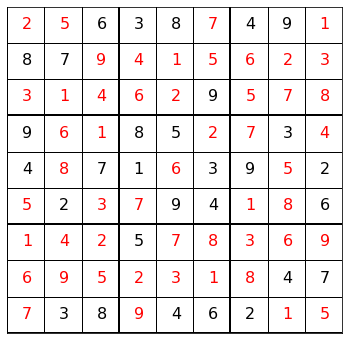

In [7]:
ans = solve(prob1)

success!
Initial known values are in black


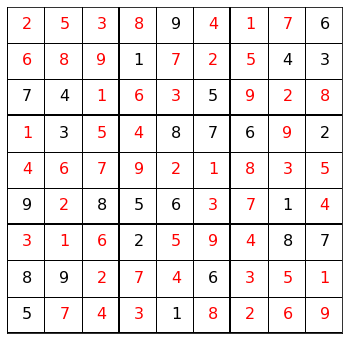

In [8]:
ans = solve(prob2)